# Barriers to adapt rStar-Math to Coding

1. Edit prompt design (generate code snippets, etc.)
2. Evaluation of code outputs (in the rating function)
    - Instead of ground-truth answer --> running the generated code to verify correctness
    - Handling edge cases and runtime errors
    - Comparing outputs against test cases
    - Handle diverse solutions --> shouldn't penalize valid but unconventional approaches
    - Store errors in failed test cases

# Dataset I am using for Leetcode Problems
https://huggingface.co/datasets/newfacade/LeetCodeDataset

In [13]:
from getpass import getpass
from dotenv import load_dotenv
import os
from openai import OpenAI

load_dotenv()
groq_key = os.getenv("GROQ_KEY", "Empty")

model = getpass("Enter the model name: ")
api_endpoint = getpass("Enter the API endpoint (default: https://api.openai.com): ")
# Models: "llama3-8b-8192", "llama3-70b-8192"
# Endpoint: "https://api.groq.com/openai"

api_endpoint = api_endpoint if api_endpoint else "https://api.openai.com"
api_key = groq_key

openai_api_base = f"{api_endpoint}/v1"

print(f"Model: {model}")
print(f"API Endpoint: {api_endpoint}")
print(f"OpenAI API Base: {openai_api_base}")
if api_key == "Empty":
    print("No API key needed.")
else:
    print(f"API Key Set")

client = OpenAI( # Intialize the OpenAI client to be used in rStar
    api_key=api_key,
    base_url=openai_api_base
)

Model: llama3-70b-8192
API Endpoint: https://api.groq.com/openai
OpenAI API Base: https://api.groq.com/openai/v1
API Key Set


In [8]:
# Full rStar-Coding Implementation
import math, random, re, ast
import numpy as np
import concurrent.futures # module for concurrent programming (manage workers and threads)


class Node:
    def __init__(self, question, state, action=None, parent=None):
        self.state = state
        self.action = action # Action taken to reach this node
        self.parent = parent
        self.original_question = question
        self.current_question = question
        self.is_answered = False
        self.children = []
        self.visits = 0
        self.value = 0
        # Add unique identifier to the node

    def is_fully_expanded(self):
        # Right now every action is expanded --> so as long as there are children, the node is fully expanded (could change this if you want multiple A1,A2,A3 for example coming from 1 node)
        return len(self.children) > 0 or self.is_answered
    
    def best_child(self, exploration_weights=1.41):
        choices_weights = []
        for child in self.children:
            if child.is_answered: # If the child is a terminal node, we don't want to explore it
                print(f"Child {child.action} is answered, setting weight to -1")
                weight = -1
            elif child.visits == 0:
                weight = float('inf') # Prioritize unexplored nodes
            else:
                weight = (child.value / child.visits) + exploration_weights * math.sqrt(math.log(self.visits) / child.visits) # UCT calculation
            choices_weights.append(weight)
        return self.children[np.argmax(choices_weights)]
    
    def most_visited_child(self): # This is used to pull the best trajectory from the MCTS tree once its generation is done (best trajectory == most likely to be the correct answer)
        return max(self.children, key=lambda child: child.visits) # Return the child with the most visits
    
    def add_child(self, child_node): # Utility function used to expand the tree
        self.children.append(child_node)

class rStarCoder:
    def __init__(self, question, num_rollouts=1, iterations=2, children_per_action=1, test_cases=[], function_name=""):
        self.root = Node(question, "Begin answering the question")
        self.question = question
        self.num_rollouts = num_rollouts
        self.iterations = iterations
        self.children_per_action = children_per_action
        self.test_cases = test_cases
        self.function_name = function_name

    def search(self):
        for i in range (self.iterations):
            print(f"Iteration {i+1}/{self.iterations}")
            node = self.select(self.root)
            print(f"Selected node: {node.action}")
            if node.action == 'A2' and not node.is_answered: # Error occured in previous A2 prompt
                reward = self.complete_A2(node)
                node.is_answered = True
                self.backpropagate(node, reward)
                continue
            if not node.is_fully_expanded():
                random_child = self.expand(node)
            reward = self.simulate(random_child)
            print(f"Simulated reward: {reward}")
            self.backpropagate(random_child, reward) # Backpropagate from the child upwards
            print("=================================================")
        print(f"Visits to most visited child: {self.root.most_visited_child().visits}")
        return self.root.most_visited_child().state

    def select(self, node):
        while node.is_fully_expanded() and node.children:
            node = node.best_child() # Must check that the node is not answered in the best_child function
        return node
    
    def expand(self, node): # Working as exptected (but might have to fix the state the children are initialized with)
        actions = self.get_valid_actions(node)
        print(f"Node action: {node.action}\nValid actions: {actions}\n")

        if node.is_answered: # Should never be reached since this is accounted for in the best_child function
            print(f"Selected node {action} is terminal, no further expansion.")
            return None # Terminal node
        
        for action in actions:  # Expand every valid action
            for i in range(self.children_per_action):
                print(f"\n-----Expanding node {i} with action: {action}-----\n")
                action_prompt_result, rating = self.create_prompt_and_execute(node.current_question, node.state, action)
                if rating != -1:
                    print("Is Answered, Rating:", rating)
                print(f"{action} response:\n\n {action_prompt_result}\n------------------------------------------")
                child_node = Node(node.original_question, action_prompt_result, action=action, parent=node)
                if rating != -1:
                    child_node.is_answered = True
                node.add_child(child_node)
                if child_node.is_answered:
                    self.backpropagate(child_node, rating) # Backpropagate the reward to the parent node of answered children

        # Any answered nodes should not be returned here to be simulated
        unanswered_children = [child for child in node.children if not child.is_answered]
        return random.choice(unanswered_children) # Return a random unanswered child, which will be simulated
    
    def simulate(self, node):
        # Have a check to see if the node is a terminal node (already answered) --> then just rate the node without simulating
        print(f"Simulating node: {node.action}")
        total_rating = 0
        for i in range(self.num_rollouts):
            rating = self.simulate_then_rate(node.original_question, node.state)
            total_rating += rating
            print(f"Simulation {i+1}/{self.num_rollouts} rating: {rating}")
        return round(total_rating / self.num_rollouts, 2) # Return the average rating of the rollouts
    
    def backpropagate(self, node, reward):
        while node is not None:
            node.visits += 1
            node.value += reward
            node = node.parent

    def get_valid_actions(self, node): # Utility function
        actions = []

        if node.parent is None: # Root node
            actions = ["A1", "A2", "A3", "A5"]
        else:
            if node.action == "A1":
                actions = ["A1", "A2", "A3"]
            elif node.action == "A2":
                actions = []
            elif node.action == "A3":
                actions = ["A1", "A2", "A3", "A4"]
            elif node.action == "A4":
                actions = ["A1", "A2", "A3"]
            elif node.action == "A5":
                actions = ["A1", "A2", "A3"]
        
        return actions
    
    # ----------------- LLM-Calling Functions -----------------
    
    def chat_completion_request_openai(self, prompt):
        messages = [
            {"role": "user", "content": prompt}
        ]
        chat_response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=1.0,
            max_tokens=500,
        )
        if chat_response.choices:
            completion_text = chat_response.choices[0].message.content
        else:
            completion_text = "No response from the model."
        return completion_text
    

    def create_prompt_and_execute(self, question, state, action):
        prompts = {
                "A1": f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "Please propose the next one-step thought to advance the reasoning process for solving the coding problem. "
            "Focus only on the immediate next step without solving the entire problem. "
            "Ensure the step is logically consistent with the existing reasoning steps. "
            "Do not provide the final answer or skip steps. Unless the next step clearly results in the final answer. "
            "Think step by step and provide only one reasoning step, use Python code format if necessary.",
                "A2": f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "You must now complete the reasoning process to solve the coding problem entirely. "
            "Think step by step and ensure logical consistency with the existing reasoning steps. "
            "Provide natural language reasoning when thinking step by step. "
            "Provide the final answer at the END of your response, it MUST be in the following format: 'THE FINAL ANSWER IS: ```python <your fully executable code snippet> ```'. "
            "This format MUST be strictly followed word for word to avoid ambiguity. ", # Force the model to use the format
            # "Do not skip steps or provide incomplete reasoning. "
            # "Ensure that your response is comprehensive, logically sound, and adheres to Python syntax. ",
                "A3": f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "Please propose the next sub-question to simplify the coding problem further. "
            "The sub-question answer should make a clear step towards solving the problem. "
            "After proposing the sub-question, provide its answer in Python code format. "
            "Ensure the sub-question logically follows from the existing reasoning steps. "
            "Do not solve the entire problem or skip intermediate sub-questions. "
            "Think step by step and provide only one sub-question and its answer in Python code format.",
                "A4": f"Sub-Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "The sub-question might have been answered incorrectly. "
            "Please re-answer the last sub-question using few-shot chain-of-thought reasoning. "
            "Focus only on answering the sub-question accurately and logically. "
            "Provide a detailed explanation and a verified final answer to the sub-question in Python code format. "
            "Do not reference the original answer or provide additional sub-questions. "
            "Ensure logical consistency in your reasoning.",
                "A5": f"Original Question: {question}\n"
            "The original question might be misunderstood or unclear. "
            "Please rephrase the question to make it simpler and easier to understand. "
            "Clearly list all conditions and constraints provided in the problem statement. "
            "Ensure that no information is lost or altered during the rephrasing process. "
            "Do not solve the question or provide an answer. "
            "Focus only on rephrasing the question for clarity.",
        }
        if action != 'A2':
            prompt = (
                prompts[action] +
                "\n\nIMPORTANT: If your reasoning leads to the final answer of the coding problem, you MUST explicitly state it in the following format: 'The Final Answer is: ```python <your code snippet> ```'."
                "\nIf you are answering a sub-question, you MUST clearly provide the final answer to that sub-question in the following format instead: 'The Sub-Question Answer is: ```python <your code snippet> ```'\n"
                "\nEnsure that this format is strictly followed to avoid ambiguity.\n"
                "\nDo not include the text 'The Final Answer is: ```python <your code snippet> ```' or 'The Sub-Question Answer is: ```python <your code snippet> ```' in your response otherwise\n"
            )
        else:
            prompt = prompts[action]

        action_response = self.chat_completion_request_openai(prompt)

        cumulative_state = state + "\n\n-------------------NEXT STEP-------------------\n\n" + action_response # Previous state + new_state (this should be optimized in the future to better effect downstream nodes, PARTICULARLY important for larger problems)

        # Initialize rating as -1
        rating = -1
        try:
            if re.search(r"The Final Answer is:", cumulative_state, re.IGNORECASE):
                rating = self.rate_final_answer(question, cumulative_state)
        except Exception as e:
            print(f"Error checking for final answer: {e}")

        return cumulative_state, rating


    def simulate_then_rate(self, question, state):
        prompt = (
            f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "Please propose the remaining reasoning steps to solve the coding problem completely. "
            "Think step by step and ensure logical consistency with the existing reasoning steps. "
            "Provide natural language reasoning when thinking step by step. "
            "Provide the final answer at the END of your response, it MUST be in the following format: "
            "'The Final Answer is: ```python <your fully executable code snippet> ```'. "
            "This format MUST be strictly followed word for word to avoid ambiguity. "
        )
        simulated_answer = self.chat_completion_request_openai(prompt)
        
        return self.rate_final_answer(question, state+"\n\n"+simulated_answer) # Simulated trajectory is not saved, only the rating is used to backpropagate the reward
    

    def complete_A2(self, node):
        prompt = (
            f"Question: {node.original_question}\n"
            f"Existing Reasoning Steps: {node.state}\n"
            "Please propose the remaining reasoning steps to solve the coding problem completely. "
            "Think step by step and ensure logical consistency with the existing reasoning steps. "
            "Provide natural language reasoning when thinking step by step. "
            "Provide the final answer at the END of your response, it MUST be in the following format: "
            "'The Final Answer is: ```python <your fully executable code snippet> ```'. "
            "This format MUST be strictly followed word for word to avoid ambiguity. "
        )
        rest_of_answer = self.chat_completion_request_openai(prompt)
        node.state = node.state+"\n\n"+rest_of_answer # Append the rest of the answer to the state

        return self.rate_final_answer(node.original_question, node.state) # Simulated trajectory is not saved, only the rating is used to backpropagate the reward
    

    def rate_final_answer(self, question, state): # **** test_cases and function_name are passed into the rStar constructor ****
        print("Rating the final answer...\n")
        # Extract executable Python code from the state
        final_python_code = self.chat_completion_request_openai(f"Return the python code below 'Final Answer' in the state. Do not provide any additional words since this code must be executable.\nState:\n {state}")
        match = re.search(r"(class Solution:.*)", final_python_code, re.DOTALL)
        if match:
            final_python_code = match.group(1)
        else:
            print("Error: 'class Solution:' not found in the extracted code.")
            return 0 # Here just judge logical consistency (but penalize for not finding the correct executable code)
        final_python_code = "from typing import List\n" + final_python_code
        print(f"Cleaned Code with Imports:\n\n{final_python_code}\n\n\n")

        # Execute the code against the test cases
        test_case_results = self.execute_test_cases(final_python_code)
        if not test_case_results:
            print("Error executing test cases, returning rating of 0.")
            return 0
        failed_cases = [case for case in test_case_results if not case["pass"]]
        print(f"Failed Cases: {failed_cases}")
        # print("Test Results:", test_case_results)

        # Rate the final answer given the question, state, and test case results
        rating_prompt = (
            f"Question: {question}\n"
            f"Answer: {state}\n"
            # f"Test Case Results: {test_case_results}\n\n"
            f"Failed Test Cases: {failed_cases}\n\n"
            "As an expert on this topic, please provide a detailed critique of the answer. "
            "Rate the answer based on correctness, completeness, and logical consistency. "
            # "If all test cases pass, confirm that the solution is correct and provide a brief explanation of why it works. "
            "If any test cases fail, the rating should be penalized. "
            "If any failed test cases are present, please identify and state the most likely errors. A non-exhaustive list of potential errors includes:\n"
            # "If any test cases fail, you MUST state which cases failed and what are the possible reasons for their failures. A non-exhaustive list of potential errors includes:\n"
            "1) Logical errors\n"
            "2) Missed edge cases\n"
            "3) One or more steps of the problem were done incorrectly (specify which step)\n"
            "4) Base case not handled correctly\n"
            "5) Inefficient use of memory or computational resources\n"
            "6) Arithmetic errors\n"
            "7) Incorrect assumptions about input constraints\n"
            "Provide only a critique, not a suggested answer. "
            "Then, rate the answer on a scale of 0 to 100. "
            "The response MUST be in the following format:\n"
            "Critique: <detailed critique>\n"
            "Errors: <if all test cases passed say PASSED here else state ERROR NAME>\n"
            "Rating: <numeric rating>\n"
        )
        rating_response = self.chat_completion_request_openai(rating_prompt)
        print(f"Rating Response:\n{rating_response}\n\n\n")

        try:
            match = re.search(r"Rating:\s*(\d+)", rating_response) # Extract rating to be used in the UCT calculation
            if match:
                rating = int(match.group(1))
                if rating > 95: # Paper limits the rating to a maximum of 95 (maybe 96+ causes poor MCTS performance)
                    rating = 95
                rating = float(rating)/100
            else:
                raise ValueError("Rating not found in the response.")
        except Exception as e:
            print(f"Error extracting rating: {e}")
            print(f"Rating response was: {rating_response}")
            rating = 0

        return rating # Simulated trajectory is not saved, only the rating is used to backpropagate the reward
    
    # ----------------- Execute Test Cases -----------------

    def execute_test_cases(self, final_code):
        print(f'Executing Test Cases with following code:\n{final_code}')
        local_vars = {}

        try:
            # Add 'List' to globals to ensure it is recognized (this shouldn't be happening but just in case, because my globals() was being inconsistent)
            from typing import List
            globals()["List"] = List # Explicitly add List to globals
            # Execute the provided code to define the function in local_vars
            exec(final_code, globals(), local_vars)
        except Exception as e:
            print(f"Error in executing provided code: {e}")
            return []
        
        # Get the Solution class
        solution_class = local_vars.get("Solution")
        if not solution_class:
            print("No 'Solution' class found in the provided code.")
            return []

        solution_instance = solution_class() # Instantiate the Solution class

        # Get the function (method) by name --> example: twoSum
        if not hasattr(solution_instance, self.function_name):
            print(f"Function '{self.function_name}' not found in 'Solution' class.")
            return []
        
        func = getattr(solution_instance, self.function_name)

        results = []
        for i, case in enumerate(self.test_cases):
            test_input = case["input"]
            expected_output = case["output"]

            try:
                # Set variables in function parameters
                exec(test_input, globals(), local_vars)
                input_vars = {}
                for line in test_input.strip().split('\n'):
                    var_name = line.strip().split('=')[0].strip()
                    input_vars[var_name] = local_vars[var_name]

                with concurrent.futures.ThreadPoolExecutor() as executor: # Use ThreadPoolExecutor for timeout control
                    future = executor.submit(func, **input_vars) # Run the function in a separate thread
                    try:
                        actual_output = future.result(timeout=10) # Waits for up to 10 seconds for test_case to finish executing --ELSE--> infinite loop (handled gracefully)
                        try:
                            expected_obj = ast.literal_eval(expected_output)
                        except Exception:
                            expected_obj = expected_output
                        is_correct = str(actual_output) == str(expected_obj)

                        print(f"Test case {i + 1}:")
                        print(f"Input: {test_input}")
                        print(f"Expected: {expected_output}")
                        print(f"Actual: {actual_output}")
                        print(f"Result: {'✅ Pass' if is_correct else '❌ Fail'}\n")

                        results.append({
                            "input": test_input,
                            "expected": expected_output,
                            "actual": actual_output,
                            "pass": is_correct
                        })
                    except concurrent.futures.TimeoutError: # Handle timeout
                        print(f"Test case {i + 1} timed out (infinite loop).")
                        # results.append({
                        #     "input": test_input,
                        #     "expected": expected_output,
                        #     "actual": None,
                        #     "pass": False,
                        #     "error": "TimeoutError: Execution exceeded the time limit, likely infinite loop."
                        # })
                        return [] # TODO: handle infinite loops better

            except Exception as e:
                print(f"Error executing test case {i + 1}: {e}")
                results.append({
                    "input": test_input,
                    "expected": expected_output,
                    "actual": None,
                    "pass": False,
                    "error": str(e)
                })

        return results


In [ ]:
# Used this dataset for sourcing problems (applied some additional custom formatting) --> https://huggingface.co/datasets/newfacade/LeetCodeDataset
import importlib
import problems.rstar_coder_problems as rstar_coder_problems
importlib.reload(rstar_coder_problems) # Reload the module to ensure the latest version is used
from problems.rstar_coder_problems import problems
# print(problems.keys())

# rstar = rStarCoder(question=problems['twoSum']['question'], num_rollouts=1, iterations=15, children_per_action=1, test_cases=problems['twoSum']['test_cases'], function_name="twoSum")
rstar = rStarCoder(question=problems['longestPalindrome']['question'], num_rollouts=2, iterations=15, children_per_action=1, test_cases=problems['longestPalindrome']['test_cases'], function_name="longestPalindrome")
rstar.search()

# TODO: add flags to the execute_test_cases function to allow for more flexibility in the test cases (e.g. if they are not in the correct format, etc.)
# Example --> longest_palindrome as long as the palindrome is the same length as the input string --> it would PASS

Iteration 1/15
Selected node: None
Node action: None
Valid actions: ['A1', 'A2', 'A3', 'A5']


-----Expanding node 0 with action: A1-----

A1 response:

 Begin answering the question

-------------------NEXT STEP-------------------

Let's think step by step. The given problem is about finding the longest palindromic substring in a given string. 

One way to approach this problem is to generate all possible substrings and check if they are palindromes. 

Here's the next reasoning step:

Let's create a function that checks if a given string is a palindrome or not. 

This can be done by comparing the string with its reverse. 

Here's the code for this step:

```python
class Solution:
    def is_palindrome(self, s: str) -> bool:
        return s == s[::-1]
```

This code snippet defines a function `is_palindrome` that takes a string `s` as input and returns `True` if `s` is a palindrome and `False` otherwise.
------------------------------------------

-----Expanding node 0 with action: A2

AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

/var/folders/lx/b4qt1jss59bdv0vzs87ly60h0000gn/T/ipykernel_21051/3243732240.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


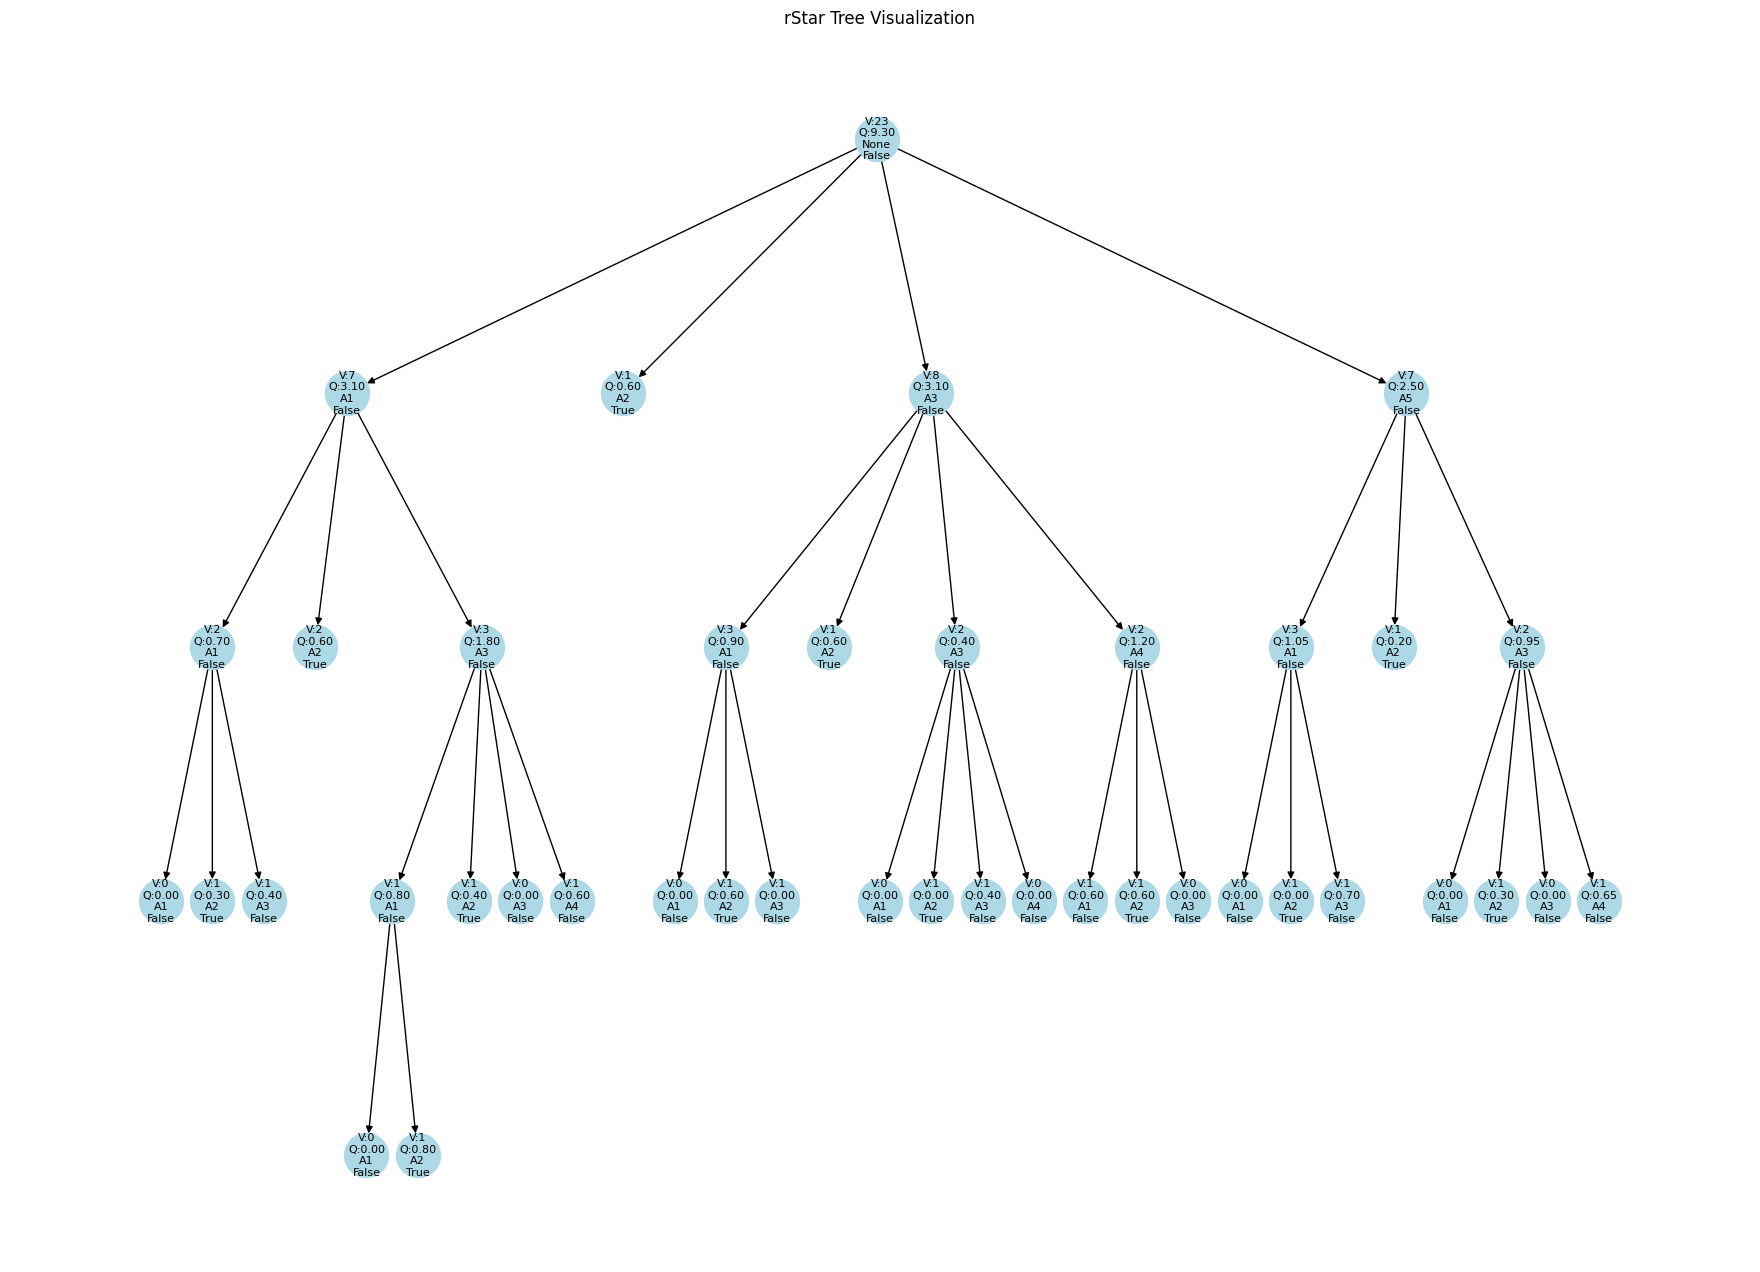

In [15]:
# Visualize rStar tree
import matplotlib.pyplot as plt
import networkx as nx

def layout_tree(tree, node, depth=0, x_offset=[0], positions={}, level_height=1.5):
    """
    Reingold-Tilford-style layout: recursively assigns x/y positions to nodes with horizontal shifting
    to avoid overlaps.
    """
    children = list(tree.successors(node))
    if not children:
        # Leaf node: assign next available x
        x = x_offset[0]
        positions[node] = (x, -depth * level_height)
        x_offset[0] += 1
        return x

    child_xs = []
    for child in children:
        cx = layout_tree(tree, child, depth + 1, x_offset, positions, level_height)
        child_xs.append(cx)

    # Center current node over its children
    min_x, max_x = min(child_xs), max(child_xs)
    x = (min_x + max_x) / 2
    positions[node] = (x, -depth * level_height)
    return x

def visualize_rstar_tree(mcts, max_nodes=100):
    graph = nx.DiGraph()
    node_labels = {}
    node_counter = [0]
    node_ids = {}

    def add_edges(node, parent_id=None):
        if node_counter[0] >= max_nodes:
            return
        node_id = node_counter[0]
        node_counter[0] += 1
        node_ids[node] = node_id

        label = (
            f"V:{getattr(node, 'visits', '?')}\n"
            f"Q:{getattr(node, 'value', '?'):.2f}\n"
            f"{getattr(node, 'action', '?')}\n"
            f"{getattr(node, 'is_answered', '?')}"
        )
        node_labels[node_id] = label
        graph.add_node(node_id)
        if parent_id is not None:
            graph.add_edge(parent_id, node_id)

        for child in getattr(node, 'children', []):
            add_edges(child, node_id)

    # Build the graph from the MCTS root
    add_edges(mcts.root)

    # Assign layout positions (no overlaps)
    positions = {}
    layout_tree(graph, 0, x_offset=[0], positions=positions, level_height=1.8)

    # Auto-adjust figure size
    num_leaves = sum(1 for n in graph.nodes if graph.out_degree(n) == 0)
    width = max(12, num_leaves * 0.6)
    depth = max(abs(y) for x, y in positions.values()) + 1
    height = max(6, depth * 1.5)

    # Draw tree
    plt.figure(figsize=(width, height))
    nx.draw(
        graph,
        pos=positions,
        with_labels=False,
        node_size=1000,
        node_color="lightblue"
    )
    nx.draw_networkx_labels(graph, pos=positions, labels=node_labels, font_size=8)
    plt.title("rStar Tree Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_rstar_tree(rstar)

In [16]:
# Jsonify rStar tree
import json

def jsonify_rstar_tree(node):
    return {
        "action": node.action if node.action else "Root",
        "summary": node.state,
        "children": [jsonify_rstar_tree(child) for child in node.children]
    }

tree_json = jsonify_rstar_tree(rstar.root)
with open("rstar_coder_tree.json", "w") as f:
    json.dump(tree_json, f, indent=4)

print("Tree successfully saved to rstar_coder_tree.json")

Tree successfully saved to rstar_coder_tree.json


In [ ]:
import openai, os, json, time
from openai import OpenAIError, RateLimitError
from dotenv import load_dotenv

load_dotenv()
embedding_client = openai.OpenAI(api_key=os.getenv("OPENAI_KEY"))

def flatten_rstar_tree(node, result=None): # Recursively flatten the rStar tree into a list of nodes.
    if result is None:
        result = []
    result.append(node)
    for child in getattr(node, 'children', []):
        flatten_rstar_tree(child, result)
    return result

def extract_node_states(tree): # Extract the state of each node in the tree as text.
    flattened_tree = flatten_rstar_tree(tree)
    node_states = []
    for i, node in enumerate(flattened_tree):
        state = getattr(node, 'state', '').strip()
        if state:  # Filter empty or low-signal nodes
            node_states.append((i, state))
    return node_states  # Returns (index, state)

def get_embeddings_batched(texts, model="text-embedding-ada-002", batch_size=100): # Generate embeddings for a list of texts in batches. (using vector with 1536 dimensions to capture semantics of state (its meaning))
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = [text for (_, text) in texts[i:i + batch_size]]
        try:
            response = embedding_client.embeddings.create(input=batch, model=model)
            batch_embeddings = [d.embedding for d in response.data]
            embeddings.extend(batch_embeddings)
        except RateLimitError:
            time.sleep(2) # Backoff if rate-limited
            continue
        except OpenAIError as e:
            print(f"OpenAI API error: {e}")
            break
    return embeddings

def save_embeddings(node_states, embeddings, out_path="node_embeddings.json"): # Save the embeddings and corresponding node states to a JSON file.
    data = [
        {"id": idx, "state": state, "embedding": emb}
        for (idx, state), emb in zip(node_states, embeddings)
    ]
    with open(out_path, "w") as f:
        json.dump(data, f, indent=4)

def generate_rstar_embeddings(rstar, out_path="node_embeddings.json"): # Generate embeddings for all node states in the rStar tree and save them.
    print("Extracting node states...")
    node_states = extract_node_states(rstar.root)

    print("Generating embeddings...")
    embeddings = get_embeddings_batched(node_states)

    print(f"Saving embeddings to {out_path}...")
    save_embeddings(node_states, embeddings, out_path)

    print("Embeddings generated and saved successfully!")


generate_rstar_embeddings(rstar, out_path="rstar_coder_node_embeddings.json") # Call generate embedding pipeline

Extracting node states...
Generating embeddings...
Saving embeddings to rstar_coder_node_embeddings.json...
Embeddings generated and saved successfully!
